# Objetivo

Utilizar el algoritmo de XGBoost para trabajar con Series Temporales. [XGBoost](https://xgboost.readthedocs.io/en/stable/) es una implementación muy popular del [Gradient Boosting](https://interactivechaos.com/es/manual/tutorial-de-machine-learning/gradient-boosting) y se ha convertido **"de facto"** en el benchmark a batir para datos tabulares.

El dataset con el que vamos a trabajar en este notebook contiene un total de **426 Series Temporales** que abarcan el periodo Enero'2013 - Septiembre'2015. 

Cada una de estas **Series Temporales** representan las ventas <u>**MENSUALES**</u> de **un artículo en un tienda y ciudad**. El objetivo es predecir las <u>**VENTAS TOTALES DEL MES DE OCTUBRE'2015**</u>.

# Librerías


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# inhabilita warnings
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [10]:
df = pd.read_csv('C:/Users/aalei/Desktop/time_series/data/ts_kaggle_train.csv', index_col = 0)
print('Rows: ', df.shape[0], '  Columns: ', df.shape[1])
df.head(2)

Rows:  14484   Columns:  8


,date,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0


In [11]:
new_name = {'monthly_sales': 'sales', 'monthly_average_price': 'price', 'unique_id':'id','city_id':'region','shop_id':'store','item_category_id':'category','item_id':'item'}
df = df.rename(columns=new_name)

# Exploratory Data Analysis EDA

In [12]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 0 to 14483
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      14484 non-null  datetime64[ns]
 1   id        14484 non-null  object        
 2   region    14484 non-null  int64         
 3   store     14484 non-null  int64         
 4   category  14484 non-null  int64         
 5   item      14484 non-null  int64         
 6   price     13262 non-null  float64       
 7   sales     13756 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1018.4+ KB


In [14]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,14484,2014-06-15 11:17:38.823529472,2013-01-31 00:00:00,2013-09-30 00:00:00,2014-06-15 00:00:00,2015-02-28 00:00:00,2015-10-31 00:00:00,NaN
region,14484.0,10.833333,0.0,7.0,7.0,16.0,23.0,6.227364
store,14484.0,31.967136,3.0,22.0,31.0,44.0,59.0,15.236351
category,14484.0,39.356808,2.0,30.0,35.0,55.0,83.0,20.439654
item,14484.0,8626.431925,32.0,4248.0,6457.0,12551.0,22088.0,5905.273346
price,13262.0,916.089314,4.928571,299.0,649.0,1149.0,9305.121212,820.945949
sales,13756.0,7.337889,0.0,2.0,5.0,9.0,30.0,7.915032


In [15]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 10)
    plot_pacf(x = y, ax = ax3, lags = 10)

    plt.suptitle(t = title, fontsize = 20)

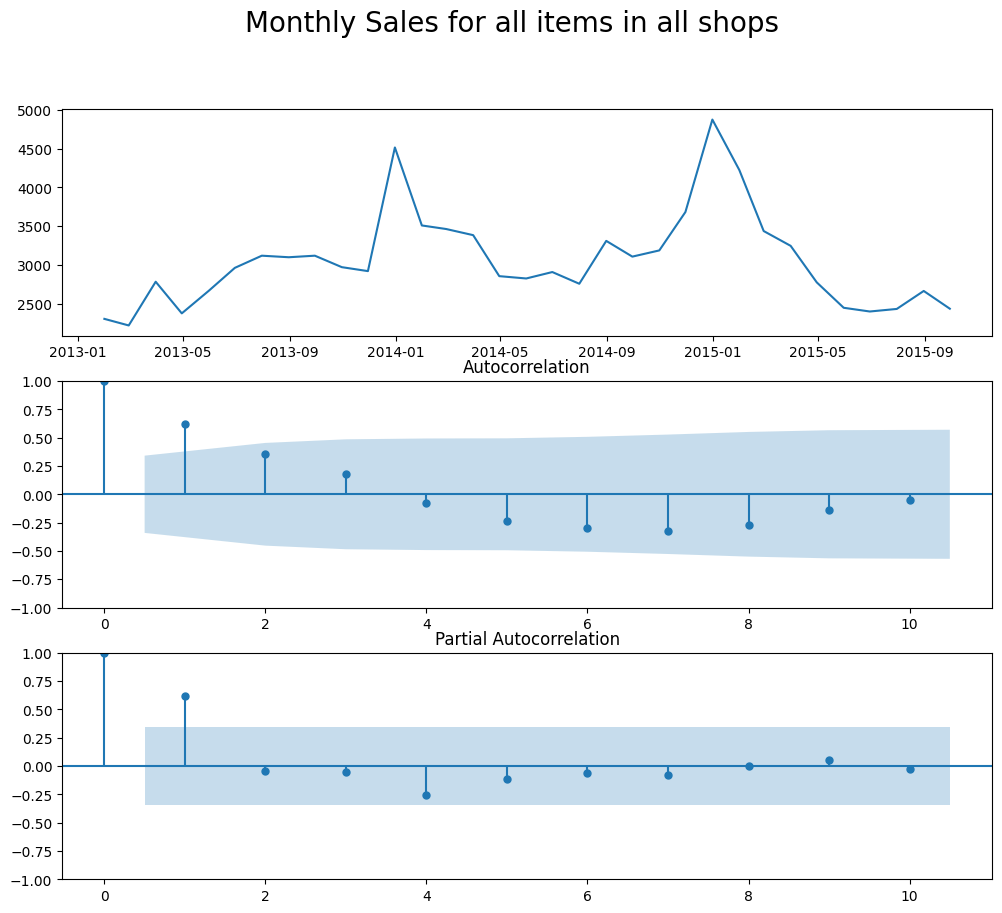

In [16]:
y = df.set_index("date").resample("M")["sales"].sum()[:-1] # quitamos los registros de octubre
plot_ts_acf_pacf(y = y, title = "Monthly Sales for all items in all shops");

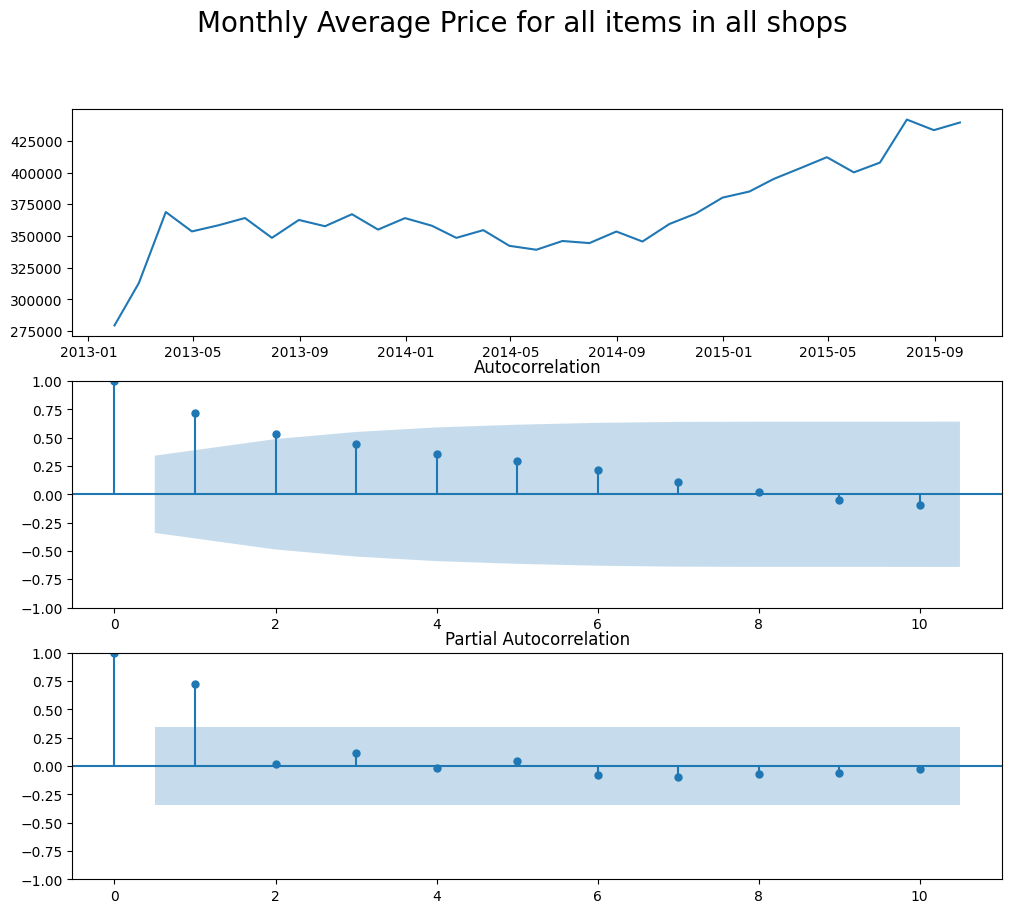

In [17]:
y = df.set_index("date").resample("M")["price"].sum()[:-1] # quitamos los registros de octubre
plot_ts_acf_pacf(y = y, title = "Monthly Average Price for all items in all shops");

In [18]:
print(f"There are {df["id"].nunique()} time series in this dataset") 

There are 426 time series in this dataset


Veamos cuales son las fechas min y max de nuestro dataset:

In [19]:
MIN_DATE = df["date"].min()
MAX_DATE = df["date"].max()
print(f"Min date is {MIN_DATE}\nMax date is {MAX_DATE}")

Min date is 2013-01-31 00:00:00
Max date is 2015-10-31 00:00:00


In [20]:
df.head(2)

,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
1,2013-01-31,12_11369,16,12,9,11369,572.715278,30.0


Veamos cuantas ciudades, tiendas, categorías e items existen:

In [21]:
print(len(df['region'].unique()), len(df['store'].unique()), len(df['category'].unique()), len(df['item'].unique()))

24 35 28 132


* De 24 ciudades diferentes (city_id -> region)
* De 35 tiendas diferentes (shop_id -> store)
* De 28 categorías de item diferentes(item_category_id -> category) 
* De 132 item diferentes (item_id -> item)

In [22]:
for col in df.columns[2:6]:
    print(f'Columna {col}:')
    print(df[col].unique())
    print('')

Columna region:
[16  3  2  4  5  6  7  8  9 10  0 12 14 13 11 15 20 17 18  1 22 23 19 21]

Columna store:
[12 14 15 16 18 19 21 22 24 25 26 28 31 35 37 38  3 41 42 44 45 46 47  4
 50 52 53 55 56 57 58 59  5  6  7]

Columna category:
[ 9 49 73 71 23 35 28 30  6 65 79  2 21 55 75 41 40 69 64 57 19 22 38 63
 83 31 76 54]

Columna item:
[11365 11369 11370 11373 12231   482   839 20949  4244  5821  5822  5823
  7856  2252  2308  2808  7893  7894 16227 17717  3077  5643  5820  1523
  1905  2445  6185 13881 16169 12232 13100 13370 18016 19331 19338   464
   491   784  8555  2753  3007  3146  3148  5380  6457 11655 11921  1249
 14842 14931 16071 16147 16167 16182 16184 16205 16210 18186  2574  4249
  5459  6738  7071  7220 12134 16209  4248  5324  7213  7895  8093 10158
 10331 10334 11081 11099 11711 11938  1201 12064 12361 12550 12551 12552
 12558 12860 13923 14247 14389 14390 15256 15303 15438 15446 15450 15458
 15459 15833 15836 17811 18672 18704 19602 21445  2182  2607  3076    32
  3656  

In [23]:
# Tiendas por ciudad
pd.set_option('display.max_columns', None)
stores_by_region = df.groupby('region')['store'].nunique()
stores_by_region_df = stores_by_region.reset_index()
stores_by_region_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
region,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
store,1,1,1,1,1,1,1,7,1,1,1,1,1,2,1,1,2,1,2,1,1,2,2,1


Podemos observar que la mayoría de regiones tienen una sóla tienda, luego hay 5 regiones con 2 tiendas y una región que tiene 7 tiendas.

In [24]:
# Categorías por tienda
category_by_store = df.groupby('store')['category'].nunique()
category_by_store_df = category_by_store.reset_index()
category_by_store_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
store,3,4,5,6,7,12,14,15,16,18,19,21,22,24,25,26,28,31,35,37,38,41,42,44,45,46,47,50,52,53,55,56,57,58,59
category,2,4,3,7,8,3,4,4,8,4,8,5,5,5,17,5,13,17,5,2,6,3,8,4,3,5,4,4,5,7,3,5,9,8,3


Podemos observar que la tienda 25 y 31 son las que tienen más categorías de venta (17 categorías diferentes), mientras que la tienda 3 y 37 tienen solo dos categorías diferentes de venta

In [25]:
# Items por categoría
item_by_category = df.groupby('category')['item'].nunique()
item_by_category_df = item_by_category.reset_index()
item_by_category_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
category,2,6,9,19,21,22,23,28,30,31,35,38,40,41,49,54,55,57,63,64,65,69,71,73,75,76,79,83
item,1,3,4,3,1,1,5,2,12,6,4,1,24,1,9,2,19,1,7,3,8,1,1,4,5,1,1,2


Podemos observar que la categoría 40 es la que más productos incluye (24), mientras que hay muchas categorías que incluyen un sólo tipo de producto.

In [26]:
# Precio Min y Max
print('Min price: ',df["price"].min(), '    Max price: ', df["price"].max())

# Ventas Min y Max
print('Min sale: ',df["sales"].min(), '    Max sale: ', df["sales"].max())

Min price:  4.928571428571429     Max price:  9305.121212120908
Min sale:  0.0     Max sale:  30.0


In [27]:
# Región con más y menos ventas
sales_by_region = df.groupby('region')['sales'].sum()
print('Región con más ventas: ', sales_by_region.idxmax(), ',', sales_by_region.max())
print('Región con menos ventas: ', sales_by_region.idxmin(), ', ', sales_by_region.min())

# Tienda con más y menos ventas
sales_by_store = df.groupby('store')['sales'].sum()
print('Tienda con más ventas: ', sales_by_store.idxmax(), ', ', sales_by_store.max())
print('Tienda con menos ventas: ', sales_by_store.idxmin(), ', ', sales_by_store.min())

# Categoría con más y menos ventas
sales_by_category = df.groupby('category')['sales'].sum()
print('Categoría con más ventas: ', sales_by_category.idxmax(), ', ', sales_by_category.max())
print('Categoria con menos ventas: ', sales_by_category.idxmin(), ', ', sales_by_category.min())

# Item con más ventas e item con menos ventas
sales_by_item = df.groupby('item')['sales'].sum()
print('Item con más ventas: ', sales_by_item.idxmax(), ', ', sales_by_item.max())
print('Item con menos ventas: ', sales_by_item.idxmin(), ', ', sales_by_item.min())

Región con más ventas:  7 , 41360.0
Región con menos ventas:  0 ,  246.0
Tienda con más ventas:  31 ,  16035.0
Tienda con menos ventas:  3 ,  246.0
Categoría con más ventas:  71 ,  19400.0
Categoria con menos ventas:  38 ,  79.0
Item con más ventas:  20949 ,  19400.0
Item con menos ventas:  12558 ,  49.0


### Top Cities

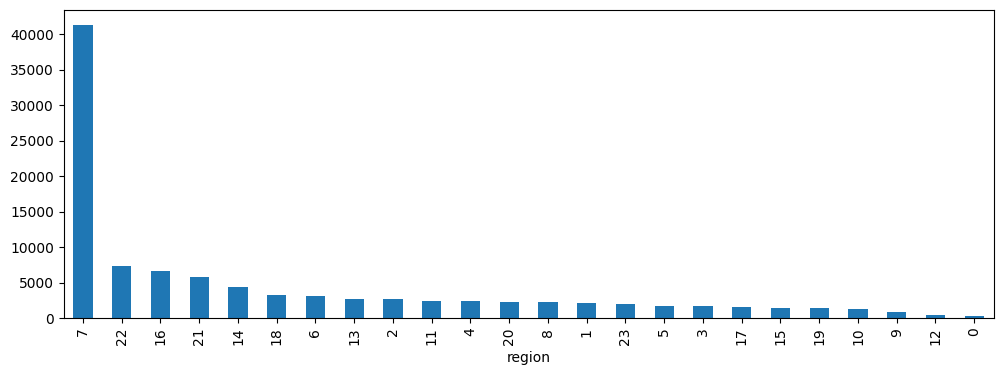

In [28]:
(
    df.
    groupby(["region"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Top Store

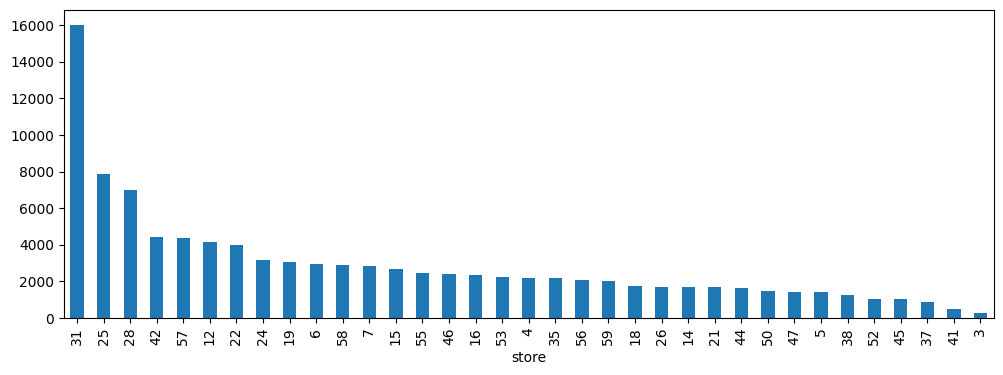

In [29]:
(
    df.
    groupby(["store"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Top Categories

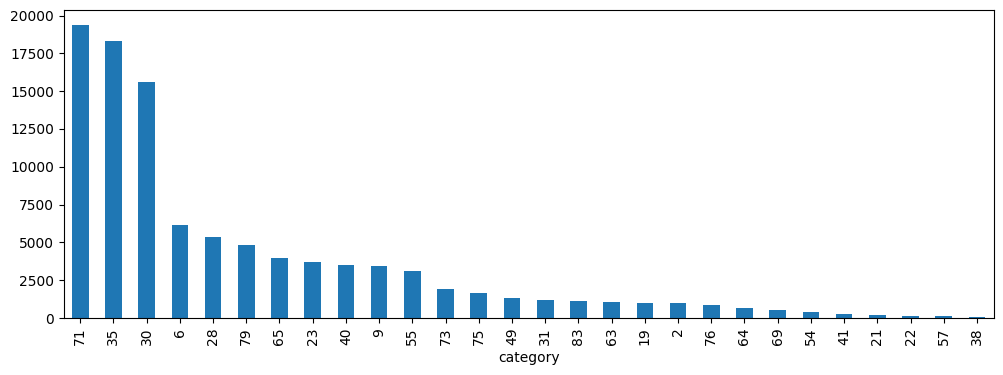

In [30]:
(
    df.
    groupby(["category"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .plot(kind = "bar", figsize = (12, 4))
);

### Top 50 Items

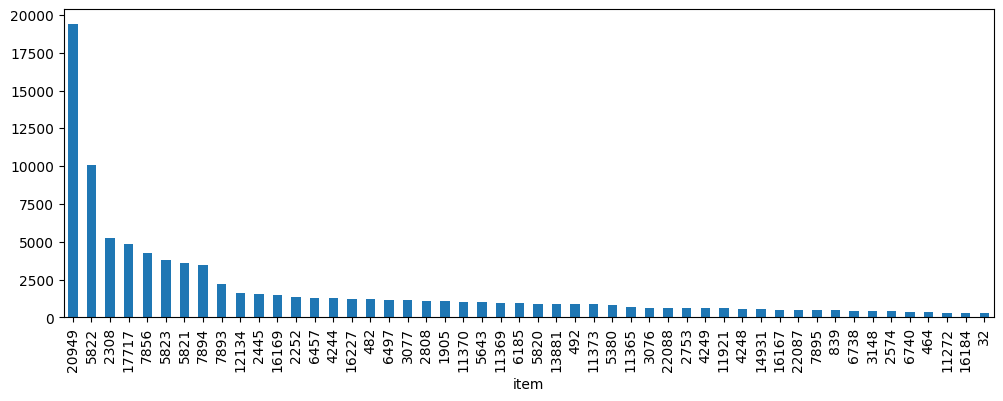

In [31]:
(
    df.
    groupby(["item"])
    ["sales"].sum()
    .sort_values(ascending = False)
    .head(50)
    .plot(kind = "bar", figsize = (12, 4))
);

# Outlayers

<Axes: ylabel='sales'>

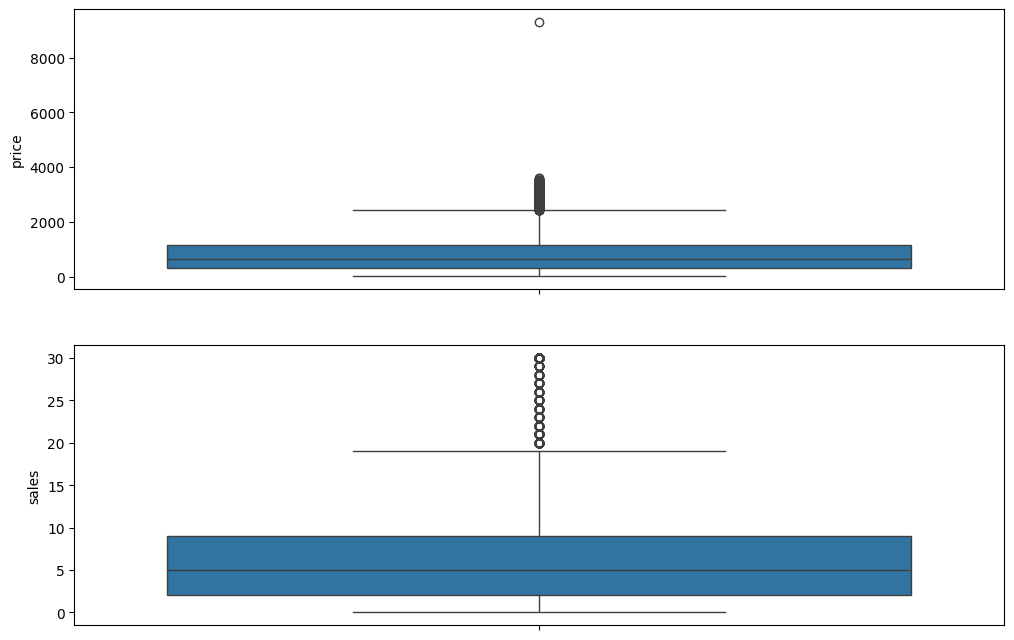

In [32]:
#Se analiza la distribucion del precio por item y el numero de items vendidos por dia mediante diagramas de box.
fig, ax = plt.subplots(2,1, figsize=(12,8))
sns.boxplot(df["price"], ax=ax[0])
sns.boxplot(df["sales"], ax=ax[1])

In [33]:
print(df['price'].max())
df[(df['id']=='12_11365')&(df['region']==16)]

9305.121212120908


,date,id,region,store,category,item,price,sales
0,2013-01-31,12_11365,16,12,9,11365,1511.512626,30.0
7,2013-02-28,12_11365,16,12,9,11365,1533.125000,27.0
14,2013-03-31,12_11365,16,12,9,11365,3252.470238,30.0
21,2013-04-30,12_11365,16,12,9,11365,1590.515152,27.0
28,2013-05-31,12_11365,16,12,9,11365,1447.531250,30.0
35,2013-06-30,12_11365,16,12,9,11365,1302.343750,28.0
42,2013-07-31,12_11365,16,12,9,11365,1736.785714,20.0
49,2013-08-31,12_11365,16,12,9,11365,3072.361111,16.0
56,2013-09-30,12_11365,16,12,9,11365,9305.121212,24.0
63,2013-10-31,12_11365,16,12,9,11365,2493.113360,30.0


In [34]:
#calcular la media con el valor anterior y posterior para el mismo id e imputar
(3072.361111 + 2493.113360)/2
df.loc[df['price'] >8000, 'price'] = 2782.7372

# Data Imputation

In [35]:
df.isnull().sum()

date           0
id             0
region         0
store          0
category       0
item           0
price       1222
sales        728
dtype: int64

In [36]:
# Selecciona las filas donde las ventas y el precio es nulo:
df.loc[(df['sales'].isnull()) & (df['price'].isnull()), ['sales', 'price']] = 0
df.isnull().sum()

date          0
id            0
region        0
store         0
category      0
item          0
price       494
sales         0
dtype: int64

In [37]:
df["price"] = df.groupby(["id","region","store","category","id"], group_keys = False)["price"].apply(
    lambda series: series.backfill().ffill()
)
df.isnull().sum().sum()

0

In [38]:
df.sort_values(["id", "date"], ascending = True, inplace = True)

# Save Data

In [39]:
df.to_csv('C:/Users/aalei/Desktop/github_dq/clean_data.csv', index=False)